## Set-up


In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *
import math

import cv2
from PIL import Image
from scipy.ndimage import binary_dilation, binary_erosion

from pymatting import *

import sys
sys.path.append('/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/DIS/IS-Net')
from DIS import getDISMask
from transparent_background import Remover

from sam_helper import *

sys.path.append('/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/matteformer')

import os
from torch.nn import functional as F
import networks


# Matte former
import utils_matteformer as utils
from inference import generator_tensor_dict, single_inference

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/susanto/miniforge3/envs/coba_torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [127]:
from sklearn.metrics import mean_squared_error

In [2]:
sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/filter')

from filter import dominantTransparent, detect_dominant_color, dominant_transparent_rgba, detect_dominant_color_rgba,color_diff_rgba

In [84]:
def getIoU(mask1,mask2):
    # Calculate intersection
    intersection = np.logical_and(mask1, mask2)

    # plt.imshow(intersection)

    # Calculate union
    union = np.logical_or(mask1, mask2)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)

    # print("Intersection:", intersection)
    # print("Union:", union)
    # print("IoU:", iou)
    return iou


In [131]:
def getSAD(rgba_img, alpha_img):
    # Extract the alpha channel
    alpha_channel1 = rgba_img[:, :, 3]
    # Calculate the SAD between the two images
    sad = np.sum(np.abs(alpha_channel1 - alpha_img))

    return sad

In [128]:
def getMSE(rgba_img,alpha_img):
    # Extract the alpha channel
    alpha_channel1 = rgba_img[:, :, 3]

    # Calculate the squared difference
    # diff = alpha_channel1 - alpha_img
    # squared_diff = diff**2

    # Calculate the mean squared error (MSE)
    # mse = np.mean(squared_diff)
    # print("MSE:", mse)

    mse = mean_squared_error(alpha_channel1.flatten(), alpha_img.flatten())

    
    return mse

In [121]:
def rgbToAlpha2D(rgb_gray_scale):
    # Convert the image to grayscale
    gray_image = np.mean(rgb_gray_scale, axis=2)

    # Normalize the pixel values between 0 and 1
    normalized_image = gray_image / np.max(gray_image)

    # Scale the values to the desired range (0-255)
    scaled_image = (normalized_image * 255).astype(np.uint8)

    return scaled_image

In [156]:
def getMSEandSAD(rgba_img, alpha_img):
    mse = getMSE(rgba_img, alpha_img)
    sad = getSAD(rgba_img, alpha_img)
    return mse, sad


## Example image


In [31]:
file_name_origin = "o_5d53cc84"
image_path = 'AIM500/original/'+file_name_origin+".jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


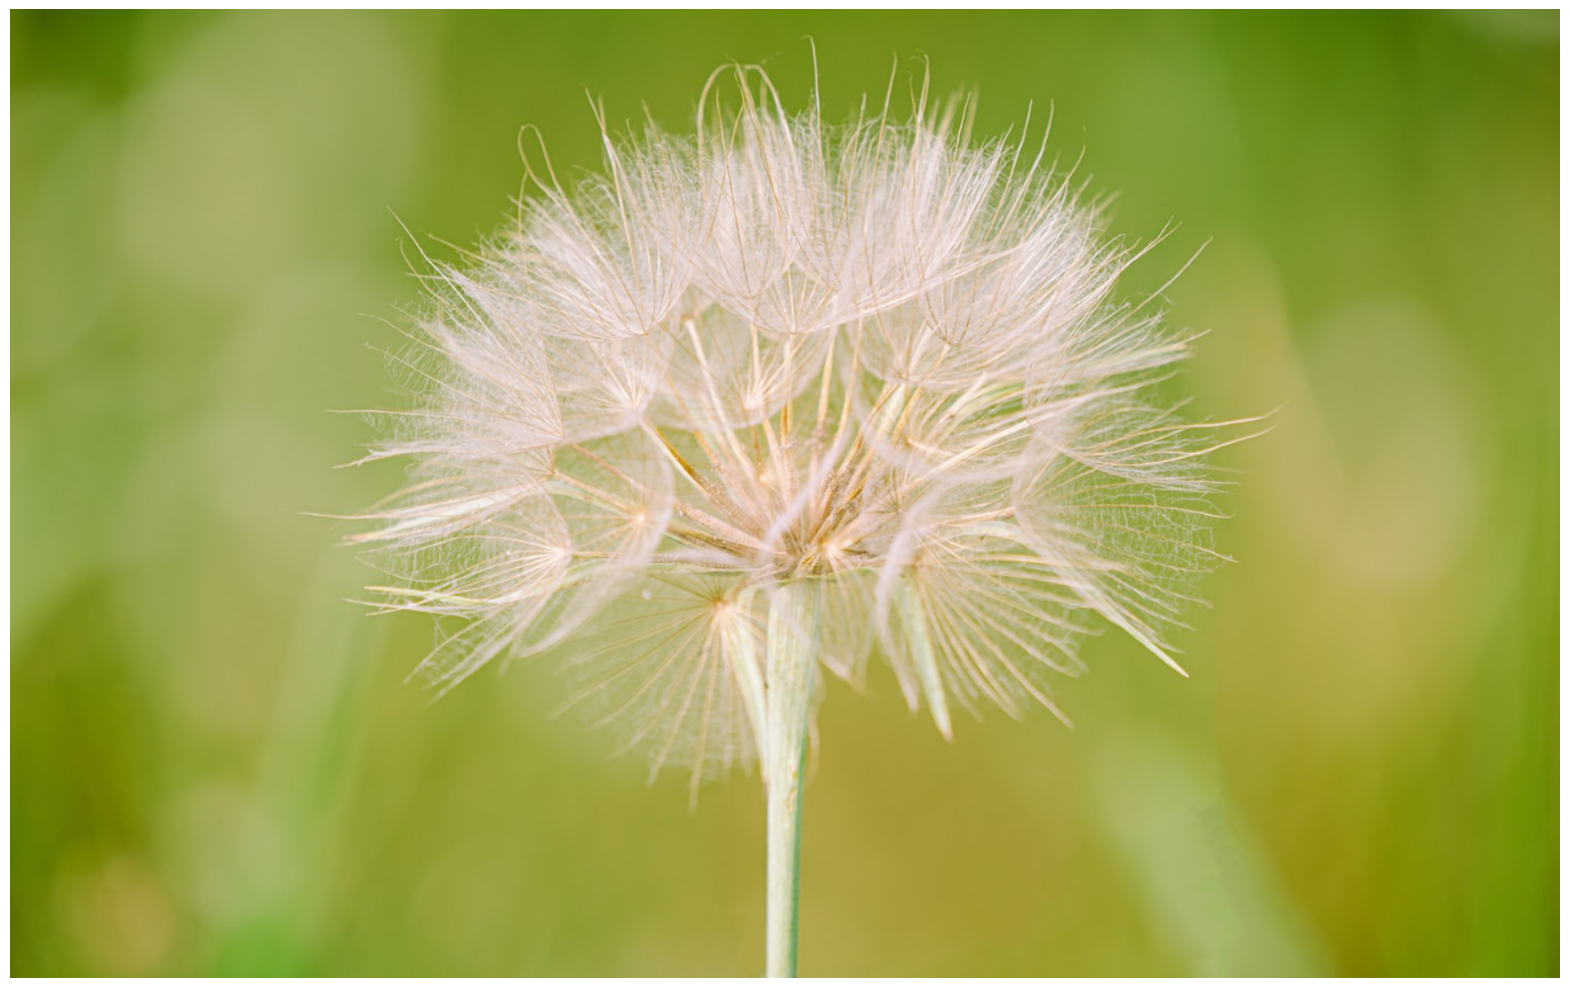

In [29]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Segment Anything Model

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.


In [7]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [8]:
print(len(masks))
print(masks[0].keys())


12
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [9]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


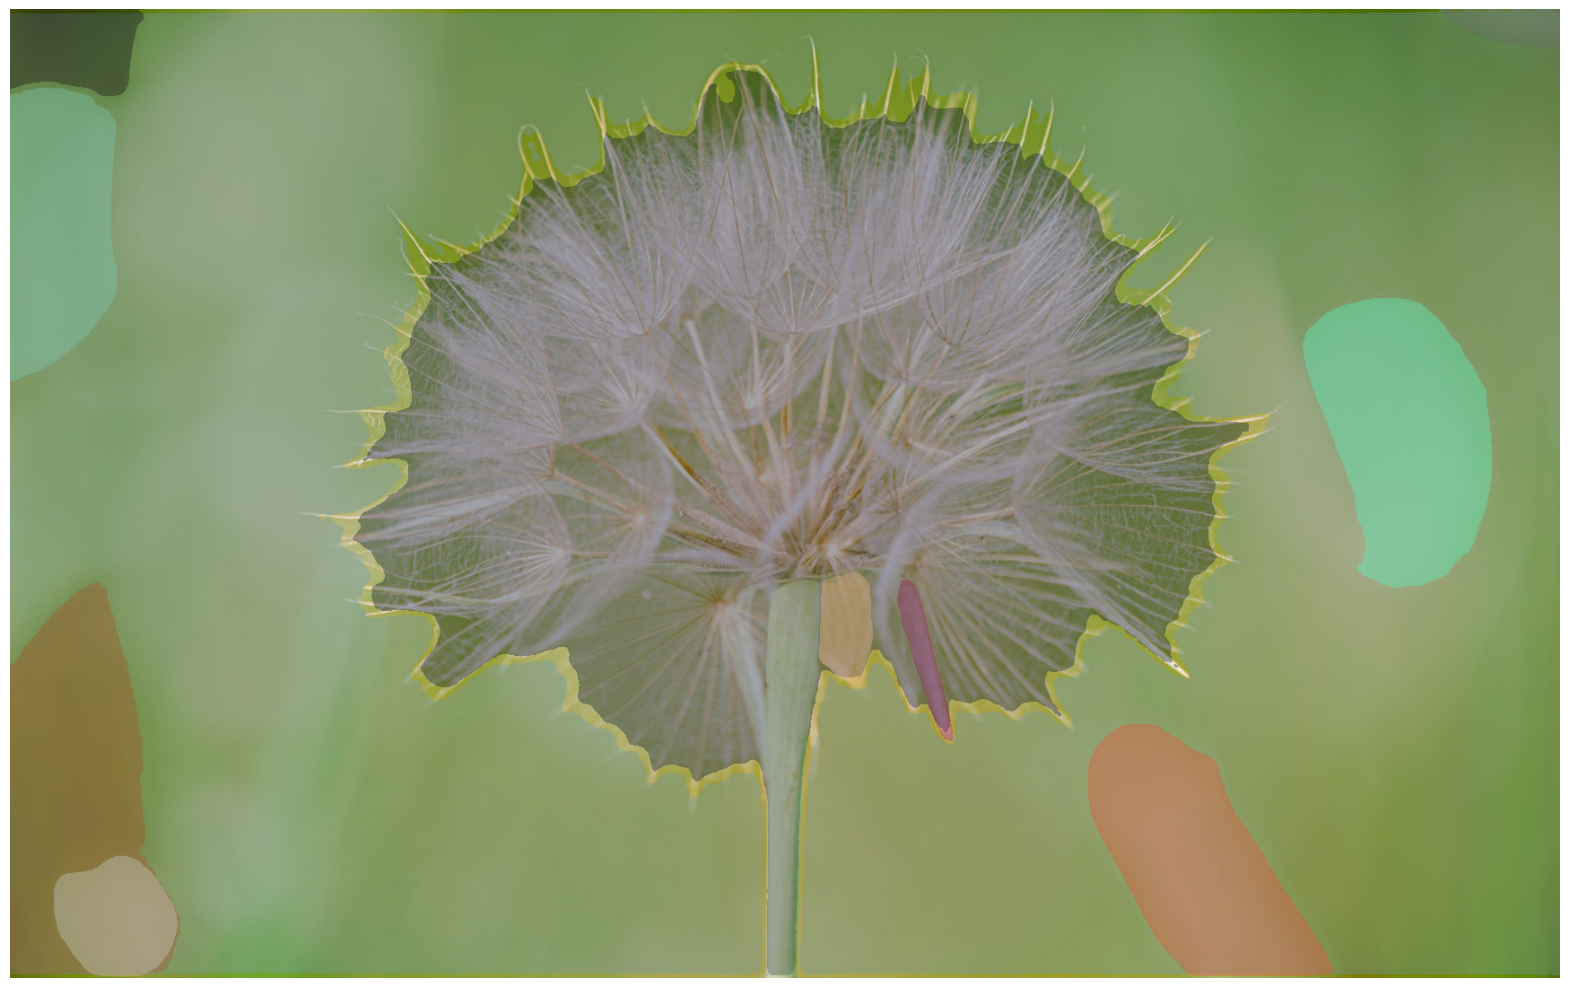

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


In [10]:
# image_path = 'images/gawang.jpg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Post Processing

SAM -> InSpyRev -> MatteFormer

## InSPyReNet

Revisiting Image Pyramid Structure for High Resolution Salient Object Detection (InSPyReNet)

https://github.com/plemeri/InSPyReNet

https://github.com/plemeri/transparent-background

In [11]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask


In [12]:
# InSPyReNet Remover Tool
model_path_InSPyReNet = "/Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_SwinB_Large.pth"

remover = Remover(fast=True, jit=True, device='cpu',
                  ckpt=model_path_InSPyReNet)  # custom setting


B /Users/susanto/Documents/Proyek/best-remove-background/models/InSPyReNet_SwinB_Large.pth
Settings -> Mode=fast, Device=cpu, Torchscript=enabled


In [13]:
PIL_image = Image.fromarray(rgba_image)
PIL_image.save('output/all.png')

PIL_image = PIL_image.convert("RGB")
PIL_image.save('output/all.jpg')

In [14]:
PIL_image = Image.open('output/all.jpg')
out = remover.process(PIL_image)  # default setting - transparent background

Image.fromarray(out).save('output/all_InSPyReNet.png') # save result

## Image Matting using MatteFormer

https://github.com/webtoon/matteformer

In [15]:
def saveMask(mask, name="example.jpg"):
    # Convert the binary mask to grayscale image
    gray_image = mask.astype(np.uint8) * 255

    a = Image.fromarray(gray_image)
    a.save("output/"+name)


In [16]:
def makeTrimap(img, s_size=2, name="example"):
    # Step 1: Select Only Main Visible Area
    main_area_mask = img[:, :, 3] > 170
    # plt.imshow(main_area_mask)

    # Step 2: Detect Edges (For nets rope, etc)
    # limit edge detection to visible area only
    visible_area = img.copy()
    visible_area[img[:, :, 3] < 200] = [0, 0, 0, 0]
    PIL_image, bounding = cropUnusedBlankPixel(visible_area)
    x, y, x1, y1 = bounding
    croped_img = img[y:y1, x:x1]

    # Convert RGBA image to grayscale
    gray_image = cv2.cvtColor(
        croped_img.astype(np.uint8), cv2.COLOR_RGBA2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    threshold = 0  # Set the threshold value
    edges_mask = edges > threshold

    # Back to original size
    blank_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    blank_img = blank_img != 0
    edges_mask = patchToBoundingBox(blank_img, bounding, edges_mask)

    # Remove outside visible_area
    visible_area = img[:, :, 3] > 20
    edges_mask = np.logical_and(edges_mask, visible_area)
    # plt.imshow(edges_mask)

    # Step 3: Perform Closing Into Edge region
    dilated = binary_dilation(edges_mask, structure=np.ones((s_size, s_size)))
    closed_edge_mask = binary_erosion(
        dilated, structure=np.ones((s_size, s_size)))

    # plt.imshow(dilated)

    # Step 4: main_area_mask + closed_edge_mask
    fore_mask = np.logical_or(main_area_mask, closed_edge_mask)

    # Step 5: Get Transition Mask
    erosion_fore_mask = binary_erosion(
        fore_mask, structure=np.ones((s_size, s_size)))
    dilated_fore_mask = binary_dilation(
        fore_mask, structure=np.ones((s_size, s_size)))
    transition_mask = np.logical_and(
        dilated_fore_mask, np.logical_not(erosion_fore_mask))
    
    # plt.imshow(fore_mask)

    # Add more transition_mask based on closed_edge_mask
    transition_mask = np.logical_or(transition_mask, closed_edge_mask)

    backbone = binary_erosion(
        closed_edge_mask, structure=np.ones((s_size+1, s_size+1)))
    # plt.imshow(backbone)

    absolute_foreground = img[:, :, 3] == 255

    backbone = np.logical_or(absolute_foreground, backbone)

    f = (img[:, :, 3] < 250) & (img[:, :, 3] > 50)

    # Create the trimap
    trimap = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    trimap[fore_mask] = 255
    trimap[transition_mask] = 127
    trimap[f] = 127
    trimap[backbone] = 255


    # saveMask(fore_mask, "fore.jpg")
    # saveMask(transition_mask, "transition_mask.jpg")
    # saveMask(backbone, "backbone.jpg")
    # saveMask(f, "fa.jpg")

    return trimap.astype(np.uint8)


In [17]:
def makeTrimap1(rgba_image, threshold=0.5, dilation_size=5, erosion_size=3):
    # Extract the alpha channel
    alpha_channel = rgba_image[:, :, 3]

    # Threshold the alpha channel to create a binary mask
    _, binary_mask = cv2.threshold(alpha_channel, threshold * 255, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to refine the binary mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilation_size, dilation_size))
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (erosion_size, erosion_size))
    eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)

    # Create the trimap by subtracting the eroded mask from the dilated mask
    trimap = dilated_mask - eroded_mask

    

    return trimap

In [18]:
trimap= makeTrimap(out)

# print(trimap)

koko = Image.fromarray(trimap)

koko.save("output/all_trimap.jpg")

# plt.imshow(trimap)


Image Matting using Pymatting

In [19]:
image = load_image("output/all.jpg", "RGB")
trimap = load_image("output/all_trimap.jpg", "GRAY")

alpha = estimate_alpha_lbdm(
    image,
    trimap,
    laplacian_kwargs={"epsilon": 1e-6},
    cg_kwargs={"maxiter": 2000})

alpha = (alpha * 255)
cr = rgba_image.copy()

cr[:, :, 3] = alpha
# print(alpha.shape)
# print(alpha)

PIL_image = Image.fromarray(cr)
PIL_image.save("output/all_alpha.png")


PERFORMANCE WARNING:
Thresholded incomplete Cholesky decomposition failed due to insufficient positive-definiteness of matrix A with parameters:
    discard_threshold = 1.000000e-04
    shift = 0.000000e+00
Try decreasing discard_threshold or start with a larger shift



In [20]:
def image_matting_matte_former(image_path, trimap_path):
    # build model
    model = networks.get_generator(is_train=False)
    model.cpu()

    checkpoint_path = "/Users/susanto/Documents/Proyek/best-remove-background/models/matteformer_image_matting.pth"

    # build model
    model = networks.get_generator(is_train=False)
    # model.cpu()

    # load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    model.load_state_dict(utils.remove_prefix_state_dict(
        checkpoint['state_dict']), strict=True)

    # inference
    model = model.eval()

    # assume image and mask have the same file name
    image_dict = generator_tensor_dict(image_path, trimap_path)
    alpha_pred = single_inference(model, image_dict)

    return alpha_pred


In [21]:
alpha = image_matting_matte_former("output/all.jpg", "output/all_trimap.jpg")

final = rgba_image.copy()
final[:, :, 3] = alpha
Image.fromarray(final).save("output/all_matteformer.png")


In [74]:
def crop_image_with_bounding_box(img, bounding_box):
    x1, y1, x2, y2 = bounding_box
    cropped_image = img[y1:y2, x1:x2,]
    return cropped_image

In [71]:
def getImage(name, folder):
    im = Image.open("AIM500/"+folder+"/"+name)
    return np.asarray(im)


In [89]:
blank_image = np.zeros((rgba_image.shape[0], rgba_image.shape[1], 4), dtype=np.uint8)

In [167]:
def cropUnusedBlankPixelExtended(myImage):
    # https://stackoverflow.com/a/53829086
    if isinstance(myImage, Image.Image):
        PIL_image = myImage
    else:
        PIL_image = Image.fromarray(myImage.astype('uint8'), 'RGBA')

    bounding = PIL_image.getbbox()

    bounding = extendBoundaries(np.asarray(myImage), bounding, 50)

    if (bounding != None):
        PIL_image = PIL_image.crop(bounding)
    else:
        width, height = PIL_image.size
        bounding = (0, 0, width, height)

    return [PIL_image, np.array(bounding).astype(int)]


In [168]:
# Convert new masks
index = 0

arrEval = []

arr = []

for sam_mask in range(0, 1):
    evaluation = {
        "IoU_ori_vs_sam": 0,
        "IoU_ori_vs_DIS": 0,
        "IoU_ori_vs_InSpyReNet": 0,
        "IoU_ori_vs_MatteFormer": 0,
        "IoU_ori_vs_MatteFormer_DIS": 0,

        "MSE_ori_vs_sam": 0,
        "MSE_ori_vs_DIS": 0,
        "MSE_ori_vs_InSpyReNet": 0,
        "MSE_ori_vs_MatteFormer": 0,
        "MSE_ori_vs_MatteFormer_DIS": 0,

        "SAD_ori_vs_sam": 0,
        "SAD_ori_vs_DIS": 0,
        "SAD_ori_vs_InSpyReNet": 0,
        "SAD_ori_vs_MatteFormer": 0,
        "SAD_ori_vs_MatteFormer_DIS": 0,
    }

    x = masks[sam_mask]["segmentation"]

    # only if object is large enough
    if (x.shape[1] > 700):
        # Save original mask
        saveMask(x, str(index)+"_sam.jpg")

        # Evaluate
        origin_img = getImage(file_name_origin+".png", "mask")

        origin_alpha = rgbToAlpha2D(origin_img)
        origin_mask = origin_img[:, :, 2] > 0

        # Save origin image
        origin_dataset = rgba_image.copy()
        origin_dataset[:, :, 3] = origin_alpha
        PIL_image = Image.fromarray(origin_dataset)
        PIL_image.save('output/'+str(index)+"_origin_dataset.png")

        # Apply mask
        applied_mask = rgba_image.copy()
        applied_mask[x == False] = [0, 0, 0, 0]
        PIL_image = Image.fromarray(applied_mask)
        PIL_image.save('output/'+str(index)+"_origin_sam_applied.png")

        # Evaluate SAM before post processing
        iou = getIoU(origin_mask, x)
        evaluation["IoU_ori_vs_sam"] = iou

        mse, sad = getMSEandSAD(applied_mask, origin_alpha)

        evaluation["MSE_ori_vs_sam"] = mse
        evaluation["SAD_ori_vs_sam"] = sad

        # Crop aplied transparent region (aplied mask)
        [PIL_image, bounding] = cropUnusedBlankPixelExtended(PIL_image)
        PIL_image.save('output/'+str(index)+"_origin_mask.png")

        # Crop original image
        croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)
        PNG_CROPED_PATH = "output/"+str(index)+"_origin_cropped.png"
        PIL_image = Image.fromarray(croped)
        PIL_image.save(PNG_CROPED_PATH)

        # Croped original image to JPG for input InSpyReNet
        JPG_PATH = "output/"+str(index)+"_origin.jpg"
        PIL_image = PIL_image.convert("RGB")
        PIL_image.save(JPG_PATH)

        # Dichotomous Image Segmentation ______________________

        # DIS
        mask_dis = getDISMask(JPG_PATH, device="cpu")
        DIS_result = croped.copy()
        DIS_result[:, :, 3] = mask_dis

        # Back to original size
        a = blank_image.copy()
        DIS_result_origin_size = patchToBoundingBox(
            a, bounding, DIS_result)

        Image.fromarray(DIS_result_origin_size).save(
            'output/'+str(index)+"_dis.png")

        DIS_result_origin_size_mask = DIS_result_origin_size[:, :, 3] > 0

        iou = getIoU(origin_mask, DIS_result_origin_size_mask)
        evaluation["IoU_ori_vs_DIS"] = iou

        mse, sad = getMSEandSAD(DIS_result_origin_size, origin_alpha)

        evaluation["MSE_ori_vs_DIS"] = mse
        evaluation["SAD_ori_vs_DIS"] = sad

        # Trimap
        trimap = makeTrimap(DIS_result)
        Image.fromarray(trimap).save("output/"+str(index)+"_trimap_dis.jpg")

        # Image Matting: MatteFormer
        alpha_pred = image_matting_matte_former(
            JPG_PATH, "output/"+str(index)+"_trimap_dis.jpg")

        croped_a = croped.copy()
        croped_a[:, :, 3] = alpha_pred

        # Back to original size
        a = blank_image.copy()
        croped_a = patchToBoundingBox(a, bounding, croped_a)

        Image.fromarray(croped_a).save("output/"+str(index)+"_matting_dis.png")

        MatteFormer_result_mask = croped_a[:, :, 3] > 0

        iou = getIoU(origin_mask, MatteFormer_result_mask)
        evaluation["IoU_ori_vs_MatteFormer_DIS"] = iou

        mse, sad = getMSEandSAD(croped_a, origin_alpha)

        evaluation["MSE_ori_vs_MatteFormer_DIS"] = mse
        evaluation["SAD_ori_vs_MatteFormer_DIS"] = sad

        # Dichotomous Image Segmentation ______________________

        # InSpyReNet
        PIL_image = Image.open(JPG_PATH)
        InSpyReNet_result = remover.process(PIL_image)

        # Remove all region  outside dilated mask
        cropped_mask = cropToBoundingBox(x, bounding)
        dilated_mask = binary_dilation(cropped_mask)
        InSpyReNet_result[dilated_mask == False] = [0, 0, 0, 0]

        # Back to original size
        a = blank_image.copy()
        InSpyReNet_result_origin_size = patchToBoundingBox(
            a, bounding, InSpyReNet_result)

        Image.fromarray(InSpyReNet_result_origin_size).save(
            'output/'+str(index)+"_InSpy.png")

        InSpyReNet_result_origin_size_mask = InSpyReNet_result_origin_size[:, :, 3] > 0

        iou = getIoU(origin_mask, InSpyReNet_result_origin_size_mask)
        evaluation["IoU_ori_vs_InSpyReNet"] = iou

        mse, sad = getMSEandSAD(InSpyReNet_result_origin_size, origin_alpha)

        evaluation["MSE_ori_vs_InSpyReNet"] = mse
        evaluation["SAD_ori_vs_InSpyReNet"] = sad

        # Image Matting Process _______________________________

        # Trimap
        trimap = makeTrimap(InSpyReNet_result)
        Image.fromarray(trimap).save("output/"+str(index)+"_trimap.jpg")

        # Image Matting: MatteFormer
        alpha_pred = image_matting_matte_former(
            JPG_PATH, "output/"+str(index)+"_trimap.jpg")
        croped[:, :, 3] = alpha_pred

        # Back to original size
        a = blank_image.copy()
        croped_rgba = patchToBoundingBox(a, bounding, croped)

        Image.fromarray(croped_rgba).save("output/"+str(index)+"_matte.png")

        MatteFormer_result_mask = croped_rgba[:, :, 3] > 0

        iou = getIoU(origin_mask, MatteFormer_result_mask)
        evaluation["IoU_ori_vs_MatteFormer"] = iou

        mse, sad = getMSEandSAD(croped_rgba, origin_alpha)

        evaluation["MSE_ori_vs_MatteFormer"] = mse
        evaluation["SAD_ori_vs_MatteFormer"] = sad

        # Evaluate MSE
        # print(evaluation)
        arrEval.append(evaluation)
        index += 1


In [169]:
for key, value in arrEval[0].items():
    print(key + ':', value)

IoU_ori_vs_sam: 0.7265964884749624
IoU_ori_vs_DIS: 0.7653564165204612
IoU_ori_vs_InSpyReNet: 0.7312428929133593
IoU_ori_vs_MatteFormer: 0.6916716842316529
IoU_ori_vs_MatteFormer_DIS: 0.6330703058309977
MSE_ori_vs_sam: 35.42573623971193
MSE_ori_vs_DIS: 34.83225576560357
MSE_ori_vs_InSpyReNet: 35.39749710648148
MSE_ori_vs_MatteFormer: 35.068405992798354
MSE_ori_vs_MatteFormer_DIS: 34.325323645404666
SAD_ori_vs_sam: 101909336
SAD_ori_vs_DIS: 103001065
SAD_ori_vs_InSpyReNet: 94285891
SAD_ori_vs_MatteFormer: 97493808
SAD_ori_vs_MatteFormer_DIS: 107365968


In [166]:
for key, value in arrEval[0].items():
    print(key + ':', value)

IoU_ori_vs_sam: 0.7265964884749624
IoU_ori_vs_DIS: 0.76376145519745
IoU_ori_vs_InSpyReNet: 0.7312302892129129
IoU_ori_vs_MatteFormer: 0.6798037511391449
IoU_ori_vs_MatteFormer_DIS: 0.6349936624013175
MSE_ori_vs_sam: 35.42573623971193
MSE_ori_vs_DIS: 34.9364401148834
MSE_ori_vs_InSpyReNet: 35.43909143518518
MSE_ori_vs_MatteFormer: 34.92952942815501
MSE_ori_vs_MatteFormer_DIS: 34.59557452417695
SAD_ori_vs_sam: 101909336
SAD_ori_vs_DIS: 106962546
SAD_ori_vs_InSpyReNet: 95168418
SAD_ori_vs_MatteFormer: 99479493
SAD_ori_vs_MatteFormer_DIS: 108627477


In [45]:
# Convert new masks
index = 0

arr = []

x = masks[35]["segmentation"]

PIL_image = Image.fromarray(x)
[PIL_image, bounding] = cropUnusedBlankPixel(PIL_image)

cropped_mask = PIL_image
# saveMask(x,str(index)+"mask_sam.jpg")
PIL_image.save('output/'+str(index)+"_mask_sam.png")

m = rgba_image.copy()
m[x == False] = [0, 0, 0, 0]
PIL_image = Image.fromarray(m)
# PIL_image.save('output/'+str(index)+"_origin.png")

[PIL_image, bounding] = cropUnusedBlankPixel(PIL_image)

PIL_image.save('output/'+str(index)+"_origin_mask.png")

# croped = np.array(PIL_image)
croped = crop_image_with_bounding_box(rgba_image.copy(), bounding)

PNG_CROPED_PATH = "output/"+str(index)+"_origin_cropped.png"

JPG_PATH = "output/"+str(index)+"_origin.jpg"
PIL_image = Image.fromarray(croped)

PIL_image.save(PNG_CROPED_PATH)

PIL_image = PIL_image.convert("RGB")
PIL_image.save(JPG_PATH)


In [46]:
# InSpyReNet
PIL_image = Image.open(JPG_PATH)
out = remover.process(PIL_image)
Image.fromarray(out).save('output/'+str(index)+"_InSpy.png")

# Trimap
trimap = makeTrimap(out)
Image.fromarray(trimap).save("output/"+str(index)+"_trimap.jpg")

# Image Matting: MatteFormer
alpha_pred = image_matting_matte_former(
    JPG_PATH, "output/"+str(index)+"_trimap.jpg")

croped[:, :, 3] = alpha_pred

Image.fromarray(croped).save("output/"+str(index)+"_matte.png")

# index += 1


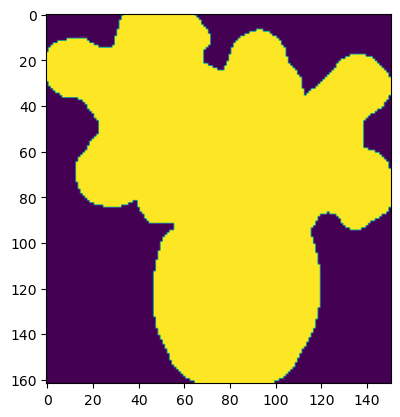

In [47]:
# Remove all region  outside dilated mask
dilated_mask = binary_dilation(cropped_mask)

plt.imshow(dilated_mask)

croped[dilated_mask == False] = [0, 0, 0, 0]

Image.fromarray(croped).save("output/"+str(index)+"_final.png")


## Evaluation

Dalam folder AIM-500

- mask : manual select alpha channel
- orignal : orignal jpg image
- trimap: trimap
- usr:  seperti trimap

In [40]:
bmp = "o_0a0ae43d"

n = Image.open("AIM500/trimap/"+bmp+".png")

n = np.asarray(n)

# print(n)

unique_values = np.unique(n)


print(unique_values)


[  0 128 255]


iou  0.9884571118372465


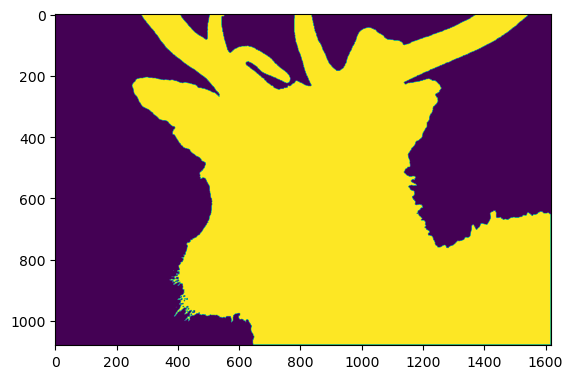

In [69]:
# Try IoU

mask1 = "o_0a0ae43d"
alpha_mask1 = Image.open("AIM500/mask/"+mask1+".png")
alpha_mask1 = np.asarray(alpha_mask1)
alpha_mask1_binary = alpha_mask1 > 0

# print(n)

# unique_values = np.unique(alpha_mask1)


# print(unique_values)

# plt.imshow(alpha_mask1)


# plt.imshow(alpha_mask1_binary)

# mask2 = "o_0a5e5a64"
# alpha_mask2 = Image.open("AIM500/mask/"+mask2+".png")
# alpha_mask2 = np.asarray(alpha_mask2)
# alpha_mask2_binary = alpha_mask2 > 0


alpha_mask2_binary = alpha_mask1_binary.copy()

erosion_fore_mask = binary_erosion(
    alpha_mask2_binary, structure=np.ones((3, 3)))
# print(alpha_mask1_binary)

iou = getIoU(alpha_mask1_binary, erosion_fore_mask)

print("iou ", iou)


In [135]:
# Evaluate
origin_img = getImage(file_name_origin+".png", "mask")

origin_alpha = origin_img[:, :, 2]
origin_mask = origin_img[:, :, 2] > 0


In [136]:
def convert_rgb_to_rgba(rgb_array, alpha=255):
    alpha_channel = np.full((rgb_array.shape[0], rgb_array.shape[1], 1), alpha, dtype=np.uint8)
    rgba_array = np.concatenate((rgb_array, alpha_channel), axis=2)
    return rgba_array


0
(1080, 1728, 4)


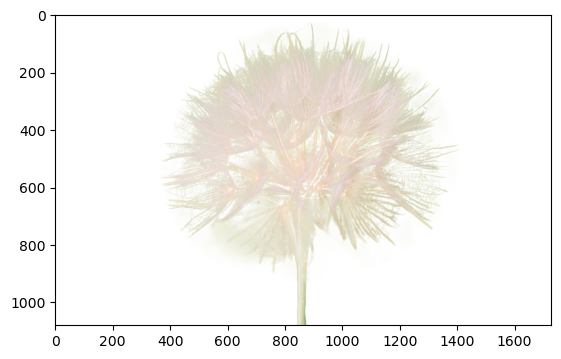

In [138]:

# Create a blank RGBA image
rgba_a = getImage(file_name_origin+".jpg", "original")
rgba_a = convert_rgb_to_rgba(rgba_a)


scaled_image = rgbToAlpha2D(origin_img)
# # Assign the alpha channel to the RGBA image
rgba_a[:, :,3 ] = scaled_image


sad = getSAD(rgba_a, scaled_image)


print(sad)
print(rgba_a.shape)
plt.imshow(rgba_a)


In [113]:
koko = np.dstack((origin_img, origin_img, origin_img, alpha_channel * 255)).astype(np.uint8)


TypeError: Invalid shape (1080, 1728, 12) for image data

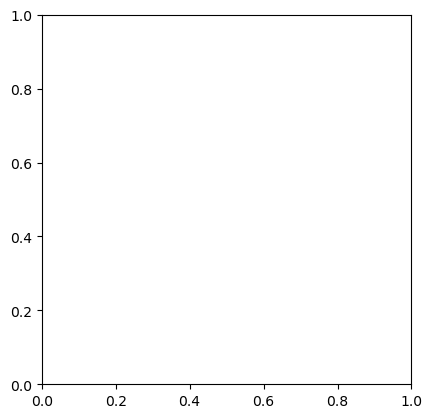

In [114]:
plt.imshow(koko)

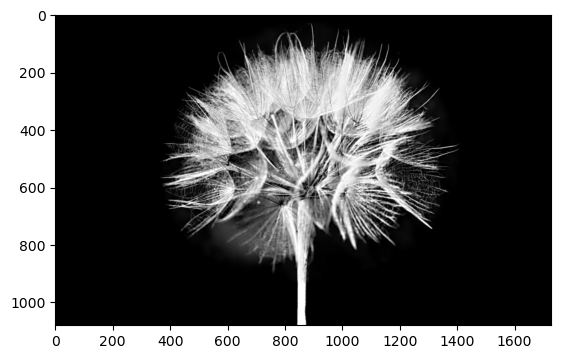

In [108]:
plt.imshow(origin_img)

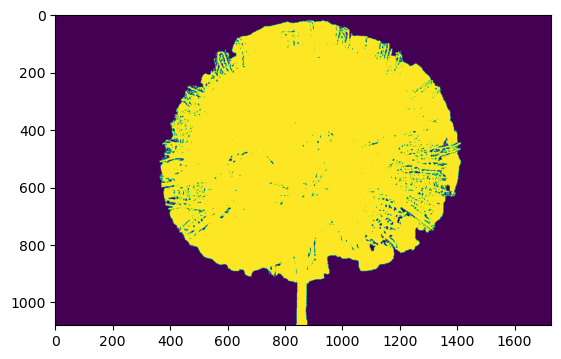

In [99]:
plt.imshow(origin_mask)

In [101]:
origin_alpha

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

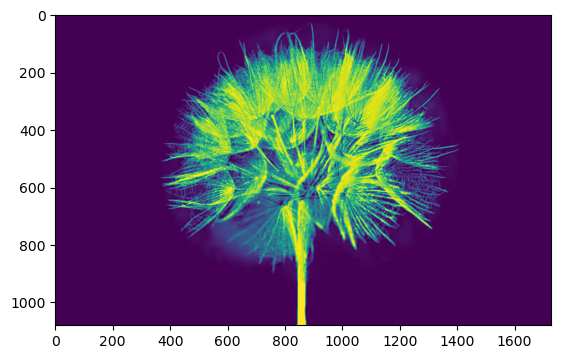

In [100]:
plt.imshow(origin_alpha)